In [6]:
import numpy as np
import torch
import torchvision as tv
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
train_transform = tv.transforms.Compose([
                tv.transforms.RandomHorizontalFlip(p=0.2),
                tv.transforms.RandomVerticalFlip(p=0.2),
                tv.transforms.RandomCrop(32, padding=2),
                #tv.transforms.RandomRotation(degrees=(-90, 90), fill=(0,0,0)),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean = [0.49139968, 0.48215827, 0.44653124], std = [0.24703233, 0.24348505, 0.26158768])])

test_transform = tv.transforms.Compose([
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean = [0.49139968, 0.48215827, 0.44653124], std = [0.24703233, 0.24348505, 0.26158768])])

trainingdata = tv.datasets.CIFAR10('../CIFAR10/',train=True,download=True, transform=train_transform)
testdata = tv.datasets.CIFAR10('../CIFAR10/',train=False,download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=32,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=32,shuffle=True)

In [9]:
class BasicBlock(torch.nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes)
            )
        self.path = tv.ops.stochastic_depth

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        #out = self.path(out, p=0.1, mode="batch")
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 128

        self.conv1 = torch.nn.Conv2d(3, 128, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(128)
        self.layer1 = self._make_layer(block, 128, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 256, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 512, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(512, num_classes)
        self.drop = torch.nn.Dropout(0.2)

    def _make_layer(self, block, planes, num_blocks, stride):
        if num_blocks != 0:
          strides = [stride] + [1]*(num_blocks-1)
          layers = []
          for stride in strides:
              layers.append(block(self.in_planes, planes, stride))
              self.in_planes = planes
          return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        #out = self.drop(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

net = ResNet(BasicBlock, [1, 1, 1]).cuda()
#net.apply(init_weights)
Loss = torch.nn.CrossEntropyLoss(label_smoothing=0.2).cuda()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.004, amsgrad=True, weight_decay=0.02)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(trainDataLoader))
total_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(total_param)

4896394


In [10]:
train_loss_history = []
test_loss_history = []

train_acc_history = []
test_acc_history = []

best_loss = 10.0
steps = 25
for epoch in range(steps):
  train_loss = 0.0
  test_loss = 0.0
  train_acc = 0.0
  test_acc = 0.0

  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images).cuda()
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    #scheduler.step(epoch + i / len(trainDataLoader))
    train_loss += fit.item()/len(trainDataLoader)
    train_acc += (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images).cuda()
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()/len(testDataLoader)
      test_acc += (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  train_acc_history.append(train_acc/len(trainDataLoader))
  test_acc_history.append(test_acc/len(testDataLoader))

  if test_loss < best_loss:
    torch.save(net.state_dict(), 'project1_model.pt')

  print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s,'
    %(epoch, train_loss, test_loss, train_acc/len(trainDataLoader), test_acc/len(testDataLoader)))
  
  if test_acc/len(testDataLoader) > 88:
    break

Epoch 0, Train loss 1.8894766176349433, Test loss 1.7090751294510809, Train accuracy 40.54502559181062, Test accuracy 51.80710862619808,
Epoch 1, Train loss 1.607468044155311, Test loss 1.5173621569959506, Train accuracy 59.506957773512475, Test accuracy 65.6349840255591,
Epoch 2, Train loss 1.493031828279913, Test loss 1.4400014690697778, Train accuracy 66.92058541266795, Test accuracy 70.72683706070288,
Epoch 3, Train loss 1.4129086218807698, Test loss 1.374403958884292, Train accuracy 71.95297504798465, Test accuracy 74.79033546325878,
Epoch 4, Train loss 1.3539663181805266, Test loss 1.3414682248910792, Train accuracy 75.69977607165707, Test accuracy 76.77715654952077,
Epoch 5, Train loss 1.3125109523058076, Test loss 1.3064011533420303, Train accuracy 78.41090850927704, Test accuracy 78.90375399361022,
Epoch 6, Train loss 1.2817068997668049, Test loss 1.2668698862337833, Train accuracy 80.16634676903391, Test accuracy 80.92052715654953,
Epoch 7, Train loss 1.2557950085428258, Test

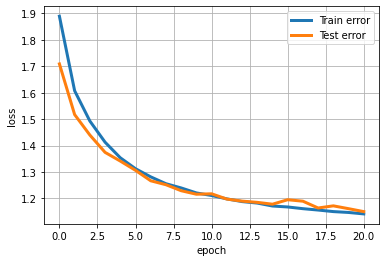

In [11]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

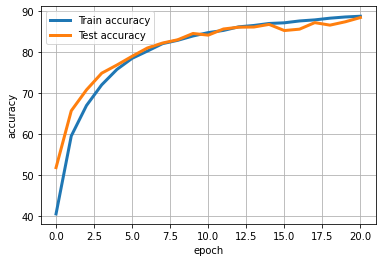

In [12]:
plt.plot(range(len(train_acc_history)),train_acc_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(len(test_acc_history)),test_acc_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()